# 0X01 Génération des parties

In [4]:
import numpy as np


In [5]:
coups = []
for i in range(1, 7):
    for j in range(i + 1, 7):
        coups.append({i, j})


In [6]:
class gen_single:
    def __init__(self):
        """
        生成单次对局
        """
        # Initialisation
        self.liste = [np.random.choice(range(15))]
        i = self.liste[-1]
        # La suite
        while i != 30:
            interdite = self.restriction(
                self.liste
            )  # Générer les coups interdite selon la règle
            possible = list(set(range(15)) - interdite)

            if possible != []:
                i = np.random.choice(possible)
            else:
                i = 30

            self.liste.append(i)
        self.liste.extend(list(np.zeros(16 - len(self.liste))))
        self.JI = self.liste[::2]
        self.JP = self.liste[1::2]

    def restriction(self, liste):
        """
        Donner les coups interdit selon les lignes déjà traitées(conservée dans liste)
        指出哪些线是不能画的
        """
        interdite = liste.copy()
        if len(liste) < 2:
            liste_self = []  # 自己划过的线
        else:
            liste_self = liste[:-2:2]  # 自己划过的线
        for i in liste_self:
            # 遍历自己已经画过的线
            points = set(range(1, 7))
            points = points - coups[i]
            for j in points:
                # 遍历和线i相连的其他线
                x, y = list(coups[i])
                m, n = list(set([x, j]))
                linenomx = -0.5 * m ** 2 + 5.5 * m + n - 7  # 顶点j对应的一根连线的编号
                m, n = list(set([y, j]))
                linenomy = -0.5 * m ** 2 + 5.5 * m + n - 7  # 另一根与j连线的编号
                if linenomx in liste_self:  # 如果相连的其他线也在liste_self中，那么就可以找到对应三角形的第三边
                    interdite.append(linenomy)
                elif linenomy in liste_self:
                    interdite.append(linenomx)
        return set(interdite)


In [7]:
gen_single().liste


[9, 5, 3, 1, 2, 13, 12, 7, 6, 8, 11, 14, 4, 30, 0.0, 0.0]

In [8]:
data = np.array([gen_single().liste for i in range(1000)]).astype(int)
data


array([[ 2,  3,  0, ..., 30,  0,  0],
       [ 5, 12,  4, ...,  0,  0,  0],
       [ 0,  5,  3, ..., 30,  0,  0],
       ...,
       [ 0, 14, 10, ..., 30,  0,  0],
       [ 5,  1, 10, ...,  0,  0,  0],
       [ 2,  1,  9, ...,  0,  0,  0]])

考虑把对局可视化的代码写一下

# 1x01 Première analyse 

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [10]:
pca = PCA(n_components=0.7)  # On se limite aux trois premiers axes
A1 = data.copy()
res1 = pca.fit(A1)


In [11]:
base = res1.components_  # 导出两个主特征向量

base[0][0::2], base[0][1::2]



(array([-0.00672262,  0.00250193,  0.01799336, -0.00981533,  0.00739722,
        -0.00428614, -0.56802656, -0.04931168]),
 array([-0.0028346 , -0.00796928,  0.00912708,  0.01165601,  0.0086837 ,
        -0.02820357,  0.8204897 , -0.00215257]))

尝试解读一下这些向量

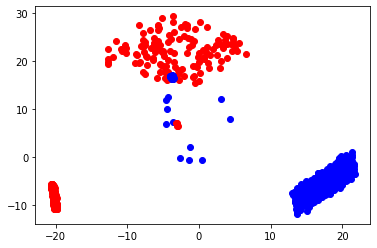

In [12]:
XX = res1.transform(A1)

n, p = A1.shape
for i in range(n):
    if (np.where(A1[i] == 30)[-1] % 2) == 0:
        plt.scatter(XX[i, 0], XX[i, 1], color="r")  # 红点先手胜
        if i == 23:
            # plt.text(0, 0,s=str(A1[i]))
            plt.text(XX[i, 0], XX[i, 1], s=str(A1[i]))  # 标出一个点的数据，分析一下
    else:
        plt.scatter(XX[i, 0], XX[i, 1], color="b")  # 蓝点后手胜


# 1x02 Analyse discriminante

In [13]:
A_Gagne = []
B_Gagne = []
gagneur = []

for i in range(n):
    if (np.where(A1[i] == 30)[0] % 2) == 0:
        A_Gagne.append(list(A1[i]))
        gagneur.append(2)
    else:
        B_Gagne.append(list(A1[i]))
        gagneur.append(1)
A_Gagne = np.array(A_Gagne)
B_Gagne = np.array(B_Gagne)


In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda


In [15]:
my_lda = lda(n_components=1)  # 这里不让我n_components大于1（就是主平面只有1维），暂时不知道问题出在哪
res = my_lda.fit(data, gagneur)
X = res.transform(data)  # Une projection ? Laquelle ??



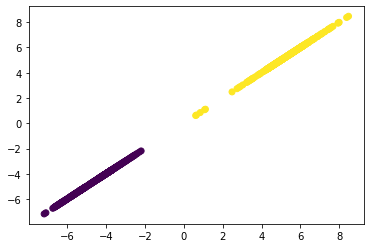

In [16]:
plt.scatter(X[:, 0], X[:, 0], c=gagneur)  # 右上先手胜，左下后手胜
# for i in range(len(a)):
#    plt.text(X[i, 0], X[i, 1], s=Noms[i])


# 2x01 Construction de fonction d'évaluation

# 2x02 实现min-max

In [88]:
class coup:
    def __init__(self, JI, JP,type=max):
        self.JI, self.JP = JI, JP
        self.max, self.min = 15, 0
        self.type=type
        self.children = []
        self.possible = self.restriction(self.type)
        self.eval()
        self.predict()

    def eval(self):
        """
        给这个节点打分（用了剩余可画线数的方式评分）
        分数保存到self.score
        """
        self.score = len(self.possible)


    def restriction(self,type):
        J=self.JI
        if type==min:
            J=self.JP
        liste = set.union(self.JI, self.JP)
        interditeI = liste.copy()

        for i in J:
            # 遍历自己已经画过的线
            points = set(range(1, 7))
            points = points - coups[i]
            for j in points:
                # 遍历和线i相连的其他线
                x, y = list(coups[i])
                m, n = list(set([x, j]))
                linenomx = -0.5 * m ** 2 + 5.5 * m + n - 7  # 顶点j对应的一根连线的编号
                m, n = list(set([y, j]))
                linenomy = -0.5 * m ** 2 + 5.5 * m + n - 7  # 另一根与j连线的编号
                if linenomx in J:  # 如果相连的其他线也在self.JI中，那么就可以找到对应三角形的第三边
                    interditeI.add(linenomy)
                elif linenomy in J:
                    interditeI.add(linenomx)
        return set(range(15)) - interditeI
        

    def predict(self):
        """
        遍历下一步的可能性
        """
        if self.isLeaf() == False:
            for i in self.possible:
                if self.type==max:
                    self.children.append(coup(self.JP, set.union(self.JI, set([i])),min))
                    self.max_score(self.children[-1])
                elif self.type==min: 
                    self.children.append(coup(self.JP, set.union(self.JI, set([i])),max))
                    self.min_score(self.children[-1])

    def isLeaf(self):
        """判断某结点是否为最终结点（无子结点）"""
        if self.possible == []:
            return True
        else:
            return False

    def max_score(self,child):
        if child.score < self.max:
            self.max = child.score

    def min_score(self,child):
        if child.score > self.max:
            self.min = child.score


In [89]:
# 生成一个对局情况
n = 5
liste = gen_single().liste
JI, JP = set(liste[: 2 * n - 1 : 2]), set(liste[1 : 2 * n : 2])
JI, JP



({0, 8, 11, 12, 13}, {3, 6, 7, 10, 14})

In [92]:
coup1 = coup(JI, JP)
coup1.predict()
tree=[[(gchild.JI, gchild.JP, gchild.score,(coup1.min,coup1.max)) for gchild in child.children] for child in coup1.children]
tree


[[({0, 1, 8, 11, 12, 13}, {2, 3, 6, 7, 10, 14}, 0, (0, 1))],
 [({0, 2, 8, 11, 12, 13}, {1, 3, 6, 7, 10, 14}, 0, (0, 1))],
 [({0, 1, 8, 11, 12, 13}, {2, 3, 6, 7, 10, 14}, 0, (0, 1))],
 [({0, 2, 8, 11, 12, 13}, {1, 3, 6, 7, 10, 14}, 0, (0, 1))]]

In [93]:
class game:
    def __init__(self, JI, JP):
        self.JI = JI
        self.JP = JP

    def update(self, JI=set(), JP=set()):
        self.JI += JI
        self.JP += JP

    def choix(self):  # todo
        for coups in self.possible():
            pass
        i = ...
        print("choix:" + str(i))
        return i

